In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                             roc_auc_score, accuracy_score)
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)

#df = pd.read_csv("C:/Users/JLai24/Desktop/video_games_sales.csv")
df = pd.read_csv("/Users/pyji/Documents/data119/project/video_games_sales.csv")

## Overview and Motivation

In recent years, the video game industry has experienced unprecedented growth. Services like Steam, a centralized platform that facilitates the distribution of games, have created an extremely accessible video game market. With more developers, from large studios to indie creators, entering the picture, the video game landscape has become increasingly competitive. As a result, understanding the factors that influence a video game’s success is becoming more crucial than ever. This project aims to explore the potential for predicting a video game’s sales using regression analysis. By creating a predictive model, developers and publishers can estimate the commercial success of a game before its release, helping them make data-driven decisions in the game design and release processes. As the industry grows more dynamic and competitive, predictive models for sales become an invaluable asset, enabling developers to stay ahead of market trends and improve their chances of reaching a wider audience.

We have decided to explore and analyze a dataset from Kaggle (https://www.kaggle.com/datasets/ulrikthygepedersen/video-games-sales). The dataset consists of over 16,000 video games and their global sales. In addition, the dataset includes regional sales data for each game from various key regions where games are of high demand (such as North America and Japan), offering a perspective on how games perform in different markets. The dataset also contains several potential explanatory variables that we can use for prediction, including the release year, genre, publisher, and platform of each game. By analyzing these factors, we can begin to understand how these contribute to the commercial success of a game. Another interesting aspect this dataset opens up is subgroup analysis due to the regional sales columns – we can make cross-regional comparisons and assess if the factors driving sales in one region continue to do so in others.

In [76]:
df.head()

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
# Basic info (row counts, dtypes, etc.)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16598 non-null  int64  
 1   name          16598 non-null  object 
 2   platform      16598 non-null  object 
 3   year          16327 non-null  float64
 4   genre         16598 non-null  object 
 5   publisher     16540 non-null  object 
 6   na_sales      16598 non-null  float64
 7   eu_sales      16598 non-null  float64
 8   jp_sales      16598 non-null  float64
 9   other_sales   16598 non-null  float64
 10  global_sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


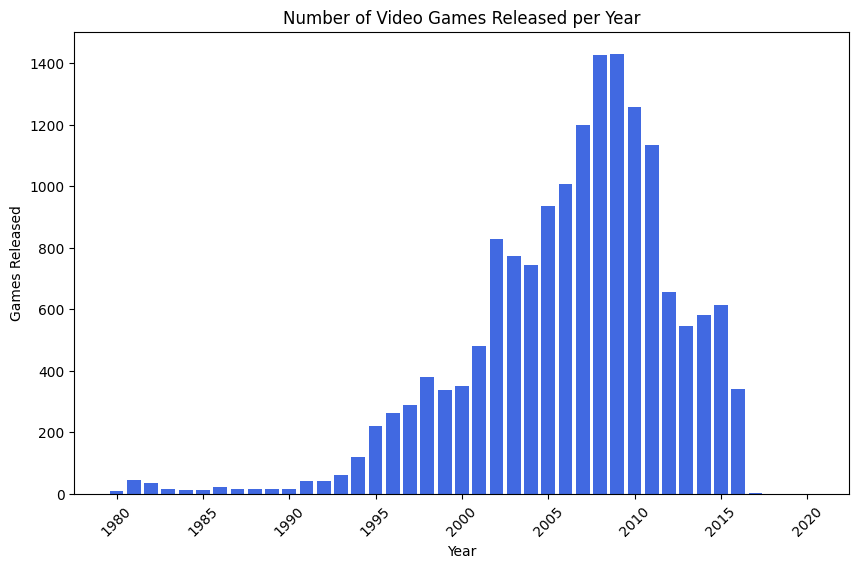

In [85]:
df_value_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(df_value_counts.index, df_value_counts.values, color='royalblue')

plt.xlabel('Year')
plt.ylabel('Games Released')
plt.title('Number of Video Games Released per Year')

plt.xticks(rotation=45)
plt.show()

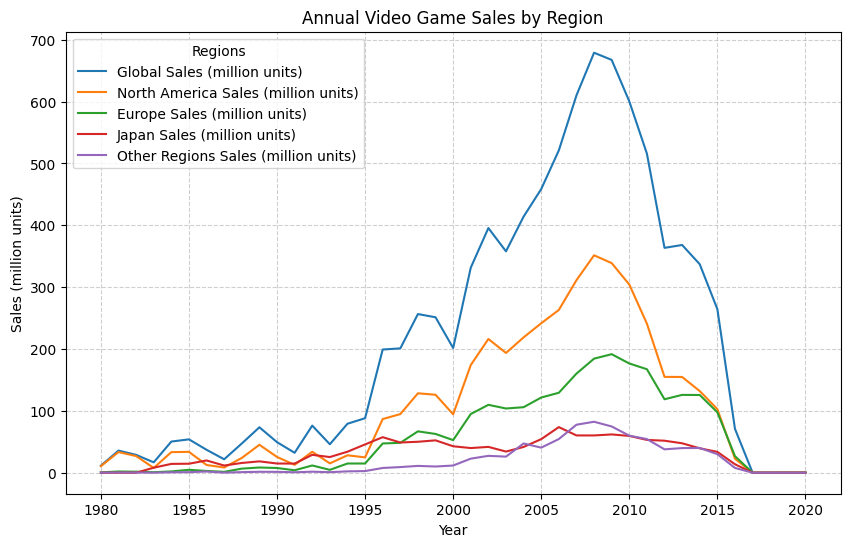

In [86]:
annual_sales = df.groupby('year').sum(numeric_only=True).reset_index()

region_labels = {
    'global_sales': 'Global Sales (million units)',
    'na_sales': 'North America Sales (million units)',
    'eu_sales': 'Europe Sales (million units)',
    'jp_sales': 'Japan Sales (million units)',
    'other_sales': 'Other Regions Sales (million units)'
}

years = annual_sales['year'].to_numpy()
plt.figure(figsize=(10, 6))

for region, label in region_labels.items():
    sales_data = annual_sales[region].to_numpy()  # Convert to numpy array
    plt.plot(years, sales_data, label=label)

plt.xlabel('Year')
plt.ylabel('Sales (million units)')
plt.title('Annual Video Game Sales by Region')
plt.legend(title="Regions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Variables Overview

* rank: Integer rank of the game by global sales
* name: String title of the game
* platform: The platform on which the game was released (e.g., Wii, NES, GB) [Categorical]
* year: Year of release (some might be missing)
* genre: Genre of the game (e.g., Sports, Platform, Racing) [Categorical]
* publisher: Publisher of the game (e.g., Nintendo) [Categorical]
* na_sales: Sales in North America (in millions)
* eu_sales: Sales in Europe (in millions)
* jp_sales: Sales in Japan (in millions)
* other_sales: Sales in the rest of the world (in millions)
* global_sales: Total worldwide sales (in millions)

In [79]:
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()
numerical_vars = df.select_dtypes(include=['number']).columns.tolist()

numerical_summary = df[numerical_vars].describe().T
numerical_summary['variance'] = df[numerical_vars].var()

global_sales = df['global_sales']

Q1 = global_sales.quantile(0.25)
Q3 = global_sales.quantile(0.75)
IQR = Q3 - Q1
outliers = global_sales[(global_sales < (Q1 - 1.5 * IQR)) | (global_sales > (Q3 + 1.5 * IQR))]

print(f"\nCategorical Variables: {categorical_vars}")
print(f"\nNumerical Variables: {numerical_vars}")
print(f"\nNumber of Outliers in Global Sales: {len(outliers)}")
print(f"Outlier Thresholds: Below {Q1 - 1.5 * IQR} or Above {Q3 + 1.5 * IQR}")


Categorical Variables: ['name', 'platform', 'genre', 'publisher']

Numerical Variables: ['rank', 'year', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']

Number of Outliers in Global Sales: 1893
Outlier Thresholds: Below -0.5549999999999999 or Above 1.085


In [80]:
global_sales = df['global_sales']

global_sales_summary = {
    "Mean": global_sales.mean(),
    "Variance": global_sales.var(),
    "Standard Deviation": global_sales.std(),
    "Min": global_sales.min(),
    "Q1 (25th percentile)": global_sales.quantile(0.25),
    "Median (Q2)": global_sales.median(),
    "Q3 (75th percentile)": global_sales.quantile(0.75),
    "IQR (Q3 - Q1)": global_sales.quantile(0.75) - global_sales.quantile(0.25),
    "Max": global_sales.max(),
    "Skewness": global_sales.skew(),
    "Kurtosis": global_sales.kurtosis()
}
global_sales_summary_df = pd.DataFrame.from_dict(global_sales_summary, orient='index', columns=['Value'])
global_sales_summary_df

,Value
Mean,0.537441
Variance,2.418112
Standard Deviation,1.555028
Min,0.010000
Q1 (25th percentile),0.060000
Median (Q2),0.170000
Q3 (75th percentile),0.470000
IQR (Q3 - Q1),0.410000
Max,82.740000
Skewness,17.400645


In [81]:
print(df.describe())

               rank          year      na_sales      eu_sales      jp_sales  \
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
std     4791.853933      5.828981      0.816683      0.505351      0.309291   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4151.250000   2003.000000      0.000000      0.000000      0.000000   
50%     8300.500000   2007.000000      0.080000      0.020000      0.000000   
75%    12449.750000   2010.000000      0.240000      0.110000      0.040000   
max    16600.000000   2020.000000     41.490000     29.020000     10.220000   

        other_sales  global_sales  
count  16598.000000  16598.000000  
mean       0.048063      0.537441  
std        0.188588      1.555028  
min        0.000000      0.010000  
25%        0.000000      0.060000  
50%        0.010000      0.170000  
75%        0.040000      0.470000  


In [82]:
print(df['global_sales'].median())

0.17


Data Cleaning and Data Wrangling

In [83]:
print(df.isnull().sum())
df.dropna(subset=['year'], inplace=True)
df.dropna(subset=['publisher'], inplace=True)

df.reset_index(drop=True, inplace=True)

df = df.drop(['rank', 'name'], axis = 1)

rank              0
name              0
platform          0
year            271
genre             0
publisher        58
na_sales          0
eu_sales          0
jp_sales          0
other_sales       0
global_sales      0
dtype: int64


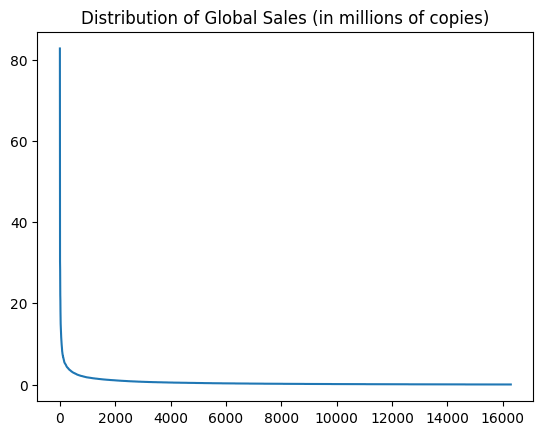

In [84]:
# Distribution of the primary response variable (global_sales)
plt.plot(df['global_sales'])
plt.title("Distribution of Global Sales (in millions of copies)")
plt.show()

Data Transformation for Global Sales: 
- Use different common bases
- Use different functions

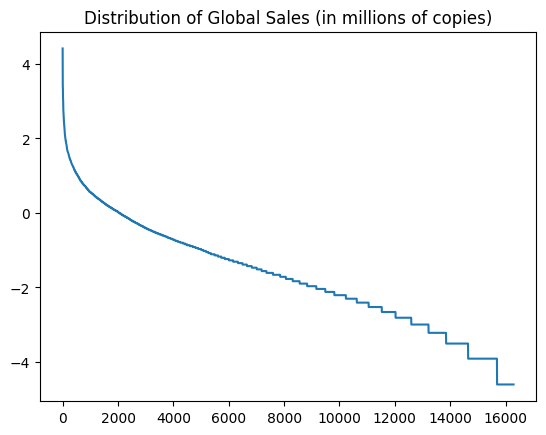

In [87]:
df['log_global_sales'] = df['log_global_sales'] = np.log(df['global_sales'])
plt.plot(df['log_global_sales'])
plt.title("Distribution of Global Sales (in millions of copies)")
plt.show()

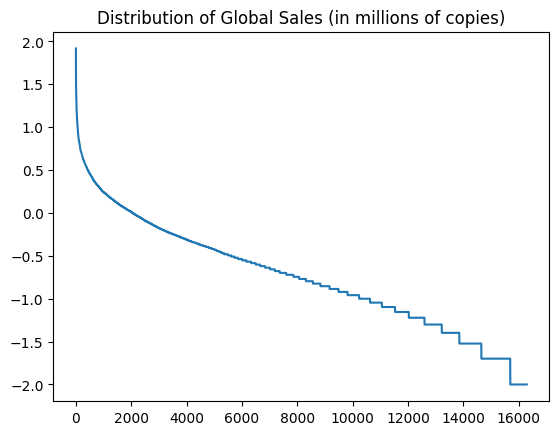

In [88]:
df['log_global_sales'] = df['log_global_sales'] = np.log10(df['global_sales']) 
plt.title("Distribution of Global Sales (in millions of copies)")
plt.show()

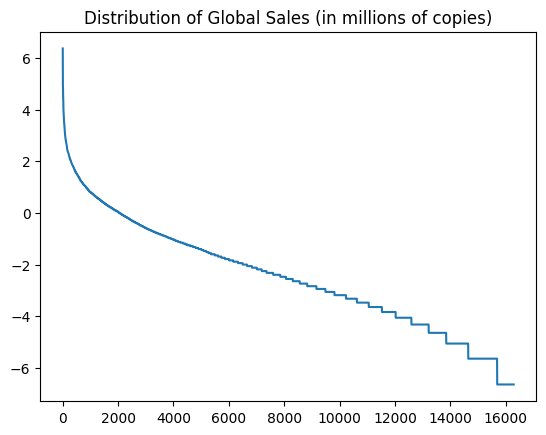

In [89]:
df['log_global_sales'] = df['log_global_sales'] = np.log2(df['global_sales']) 
plt.plot(df['log_global_sales'])
plt.title("Distribution of Global Sales (in millions of copies)")
plt.show()

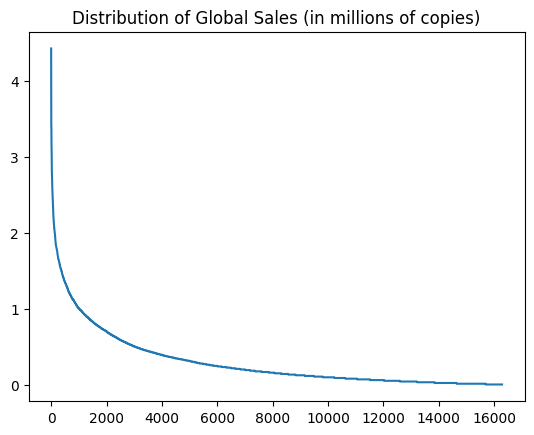

In [90]:
df['log_global_sales'] = df['log_global_sales'] = np.log1p(df['global_sales']) 
plt.plot(df['log_global_sales'])
plt.title("Distribution of Global Sales (in millions of copies)")
plt.show()

Exploration of Categorical Variables

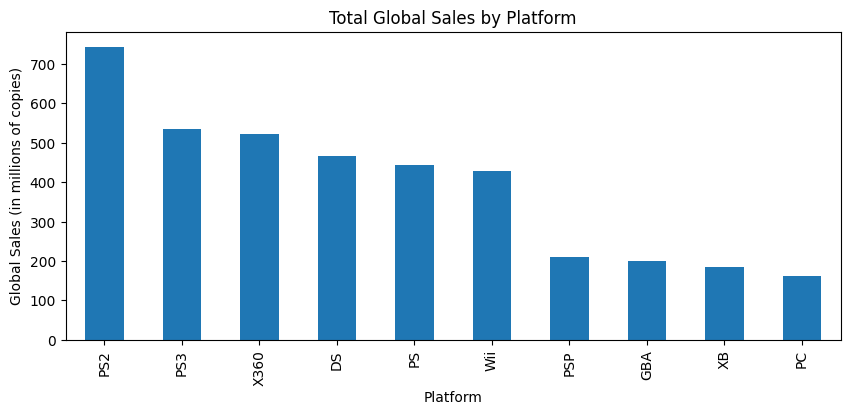

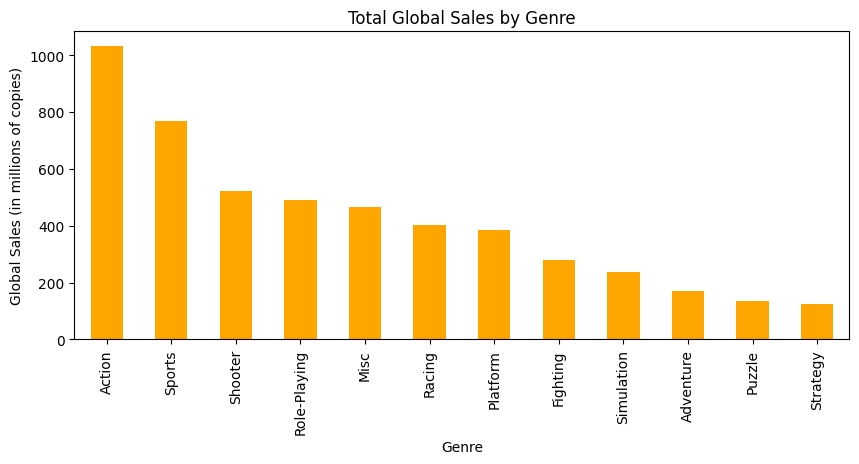

In [91]:
# Group by platform
platform_sales = df.groupby('platform')['log_global_sales'].sum().sort_values(ascending=False)
platform_sales.head(10).plot(kind='bar', figsize=(10,4))
plt.title("Total Global Sales by Platform")
plt.xlabel("Platform")
plt.ylabel("Global Sales (in millions of copies)")
plt.show()

# Group by genre
genre_sales = df.groupby('genre')['log_global_sales'].sum().sort_values(ascending=False)
genre_sales.plot(kind='bar', figsize=(10,4), color='orange')
plt.title("Total Global Sales by Genre")
plt.xlabel("Genre")
plt.ylabel("Global Sales (in millions of copies)")
plt.show()

In [92]:
#Publisher column has too many unique values (large variety of developers)
print(df['publisher'].nunique())

576


In [93]:
#Group all publishers except the top ones in the industry into 'Other', then one-hot encode
categorical_features = ['genre', 'publisher', 'platform']
top_devs = ['Activision', 'Nintendo', 'Electronic Arts', 'Ubisoft', 'Bethesda Softworks', 'Blizzard Entertainment', 'Rockstar Games', 'EA Sports', 'Valve']
df['publisher'] = df['publisher'].apply(lambda x: x if x in top_devs else 'Other')
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

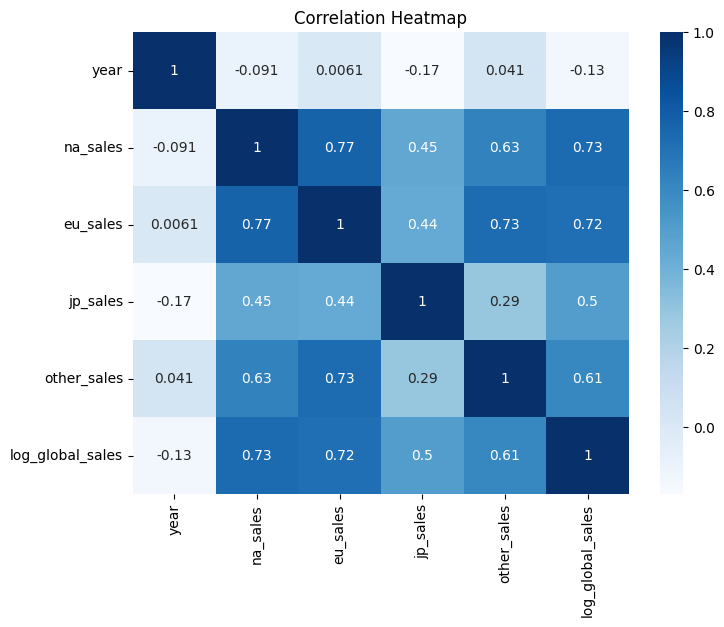

In [95]:
#Correlation matrix for numerical variables, high collinearity amongst sales columns (should not use them for prediction)
numerical_cols = ['year', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'log_global_sales']
corr_matrix = df_encoded[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

In [96]:
#Preprocessing
sales = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales', 'log_global_sales']
y = df_encoded['log_global_sales'].values
X = df_encoded.drop(sales, axis=1)

# Quick check
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (16291, 48)
Target shape: (16291,)


In [97]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Parameter Tuning & Feature Engineering

- Linear, ridge, and lasso models (no classification due to the numerical nature of the response variables)

- Evaluate models with k-fold cross validation (MAE, MSE, R^2)

- Visualizations to compare models (box/bar plots, visualizaze coefficients, residual plots, prediction vs actual, learning curves?)

- Choose best performing model and interpret coefficients

In [18]:
#Set up alphas?
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

#Set up k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
#Linear model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression MSE:", mse_lr)
print("Linear Regression MAE:", mae_lr)
print("Linear Regression R^2:", r2_lr)

Linear Regression MSE: 0.13261162849180608
Linear Regression MAE: 0.23311486754928526
Linear Regression R^2: 0.20070763612358944


In [20]:
#Ridge cv
for a in alphas:
    ridge_cv_model = Ridge(alpha=a)
    ridge_r2_scores = cross_val_score(ridge_cv_model, X_train, y_train, cv=kf, scoring='r2')
    ridge_mse_scores = cross_val_score(ridge_cv_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    ridge_mae_scores = cross_val_score(ridge_cv_model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    print(f"Alpha: {a}, Mean 5-Fold R^2: {np.mean(ridge_r2_scores):.4f}")
    print(f"Alpha: {a}, Mean 5-Fold MSE: {-np.mean(ridge_mse_scores):.4f}")
    print(f"Alpha: {a}, Mean 5-Fold MAE: {-np.mean(ridge_mae_scores):.4f}")

Alpha: 0.0001, Mean 5-Fold R^2: 0.2128
Alpha: 0.0001, Mean 5-Fold MSE: 0.1229
Alpha: 0.0001, Mean 5-Fold MAE: 0.2321
Alpha: 0.001, Mean 5-Fold R^2: 0.2128
Alpha: 0.001, Mean 5-Fold MSE: 0.1229
Alpha: 0.001, Mean 5-Fold MAE: 0.2321
Alpha: 0.01, Mean 5-Fold R^2: 0.2128
Alpha: 0.01, Mean 5-Fold MSE: 0.1229
Alpha: 0.01, Mean 5-Fold MAE: 0.2321
Alpha: 0.1, Mean 5-Fold R^2: 0.2128
Alpha: 0.1, Mean 5-Fold MSE: 0.1229
Alpha: 0.1, Mean 5-Fold MAE: 0.2321
Alpha: 1, Mean 5-Fold R^2: 0.2128
Alpha: 1, Mean 5-Fold MSE: 0.1229
Alpha: 1, Mean 5-Fold MAE: 0.2320
Alpha: 10, Mean 5-Fold R^2: 0.2121
Alpha: 10, Mean 5-Fold MSE: 0.1230
Alpha: 10, Mean 5-Fold MAE: 0.2320
Alpha: 100, Mean 5-Fold R^2: 0.2063
Alpha: 100, Mean 5-Fold MSE: 0.1239
Alpha: 100, Mean 5-Fold MAE: 0.2331


In [21]:
#Lasso cv
for a in alphas:
    lasso_cv_model = Lasso(alpha=a)
    lasso_r2_scores = cross_val_score(lasso_cv_model, X_train, y_train, cv=kf, scoring='r2')
    lasso_mse_scores = cross_val_score(lasso_cv_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    lasso_mae_scores = cross_val_score(lasso_cv_model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    print(f"Alpha: {a}, Mean 5-Fold R^2: {np.mean(lasso_r2_scores):.4f}")
    print(f"Alpha: {a}, Mean 5-Fold MSE: {-np.mean(lasso_mse_scores):.4f}")
    print(f"Alpha: {a}, Mean 5-Fold MAE: {-np.mean(lasso_mae_scores):.4f}")

Alpha: 0.0001, Mean 5-Fold R^2: 0.2121
Alpha: 0.0001, Mean 5-Fold MSE: 0.1230
Alpha: 0.0001, Mean 5-Fold MAE: 0.2320
Alpha: 0.001, Mean 5-Fold R^2: 0.2055
Alpha: 0.001, Mean 5-Fold MSE: 0.1240
Alpha: 0.001, Mean 5-Fold MAE: 0.2333
Alpha: 0.01, Mean 5-Fold R^2: 0.1165
Alpha: 0.01, Mean 5-Fold MSE: 0.1379
Alpha: 0.01, Mean 5-Fold MAE: 0.2514
Alpha: 0.1, Mean 5-Fold R^2: 0.0151
Alpha: 0.1, Mean 5-Fold MSE: 0.1537
Alpha: 0.1, Mean 5-Fold MAE: 0.2690
Alpha: 1, Mean 5-Fold R^2: -0.0007
Alpha: 1, Mean 5-Fold MSE: 0.1562
Alpha: 1, Mean 5-Fold MAE: 0.2717
Alpha: 10, Mean 5-Fold R^2: -0.0007
Alpha: 10, Mean 5-Fold MSE: 0.1562
Alpha: 10, Mean 5-Fold MAE: 0.2717
Alpha: 100, Mean 5-Fold R^2: -0.0007
Alpha: 100, Mean 5-Fold MSE: 0.1562
Alpha: 100, Mean 5-Fold MAE: 0.2717


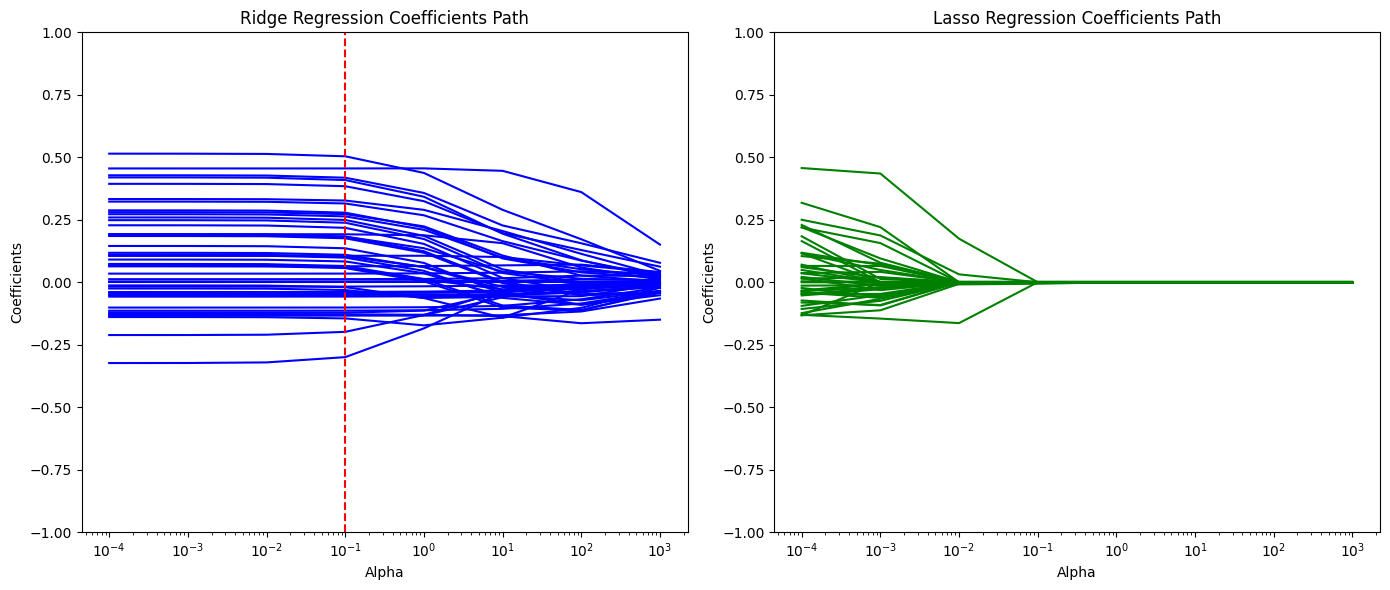

In [98]:
plotting_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_coefs = []
for a in plotting_alphas:
    ridge_model = Ridge(alpha=a)
    ridge_model.fit(X_train, y_train)
    ridge_coefs.append(ridge_model.coef_)

# Lasso Coefficient Paths
lasso_coefs = []
for a in plotting_alphas:
    lasso_model = Lasso(alpha=a)
    lasso_model.fit(X_train, y_train)
    lasso_coefs.append(lasso_model.coef_)

# Plotting the coefficient paths
plt.figure(figsize=(14, 6))

# Ridge Coefficients Path Plot
plt.subplot(1, 2, 1)
plt.plot(plotting_alphas, ridge_coefs, color='blue')
plt.ylim(-1, 1)
plt.axvline(x=0.1, color='red', linestyle='--', label='Alpha = 0.1')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Regression Coefficients Path')

# Lasso Coefficients Path Plot
plt.subplot(1, 2, 2)
plt.plot(plotting_alphas, lasso_coefs, color='green')
plt.ylim(-1, 1)  
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Regression Coefficients Path')

plt.tight_layout()
plt.show()

In [21]:
#Find best performing model (lowest mae and mse, highest r^2)
#Ridge, alpha = 0.1

In [99]:
#Cleaning column names
prefixes_to_remove = ['genre_', 'publisher_', 'platform_']
new_column_names = []

for col in X_train.columns:
    for prefix in prefixes_to_remove:
        if col.startswith(prefix):
            col = col[len(prefix):]
    new_column_names.append(col)

X_train.columns = new_column_names
X_test.columns = new_column_names

In [100]:
#best model
best = Ridge(alpha=0.1)
best.fit(X_train, y_train)

best_coef = best.coef_

print("Ridge Coefficients (alpha = 0.1):")
for i, coef in enumerate(best_coef):
    feature_name = X_train.columns[i]
    print(f"Feature: {feature_name}, Coefficient: {coef:.4f}")

Ridge Coefficients (alpha = 0.1):
Feature: year, Coefficient: -0.0174
Feature: Adventure, Coefficient: -0.1336
Feature: Fighting, Coefficient: 0.0032
Feature: Misc, Coefficient: -0.0508
Feature: Platform, Coefficient: 0.0638
Feature: Puzzle, Coefficient: -0.1012
Feature: Racing, Coefficient: -0.0391
Feature: Role-Playing, Coefficient: 0.0124
Feature: Shooter, Coefficient: 0.0345
Feature: Simulation, Coefficient: -0.0434
Feature: Sports, Coefficient: -0.0575
Feature: Strategy, Coefficient: -0.1138
Feature: Bethesda Softworks, Coefficient: 0.1918
Feature: Electronic Arts, Coefficient: 0.1057
Feature: Nintendo, Coefficient: 0.4554
Feature: Other, Coefficient: -0.1297
Feature: Ubisoft, Coefficient: -0.0496
Feature: Valve, Coefficient: 0.0000
Feature: 3DO, Coefficient: -0.1291
Feature: 3DS, Coefficient: 0.2492
Feature: DC, Coefficient: 0.1098
Feature: DS, Coefficient: 0.1758
Feature: GB, Coefficient: 0.3152
Feature: GBA, Coefficient: 0.0649
Feature: GC, Coefficient: 0.0565
Feature: GEN, Coe

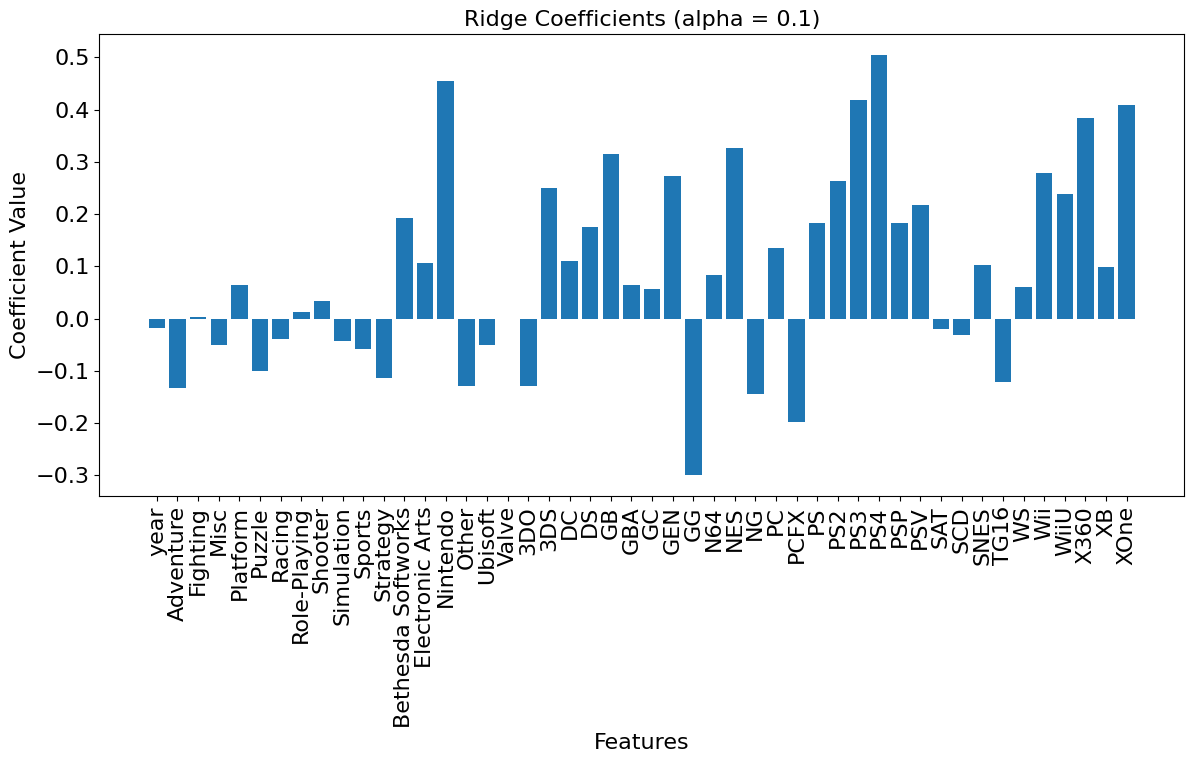

In [101]:
#coefficient plot
features = X_train.columns
plt.figure(figsize=(14, 6))
plt.bar(features, best_coef)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Coefficient Value', fontsize=16)
plt.title('Ridge Coefficients (alpha = 0.1)', fontsize=16)
plt.show()

A better Visualization Version

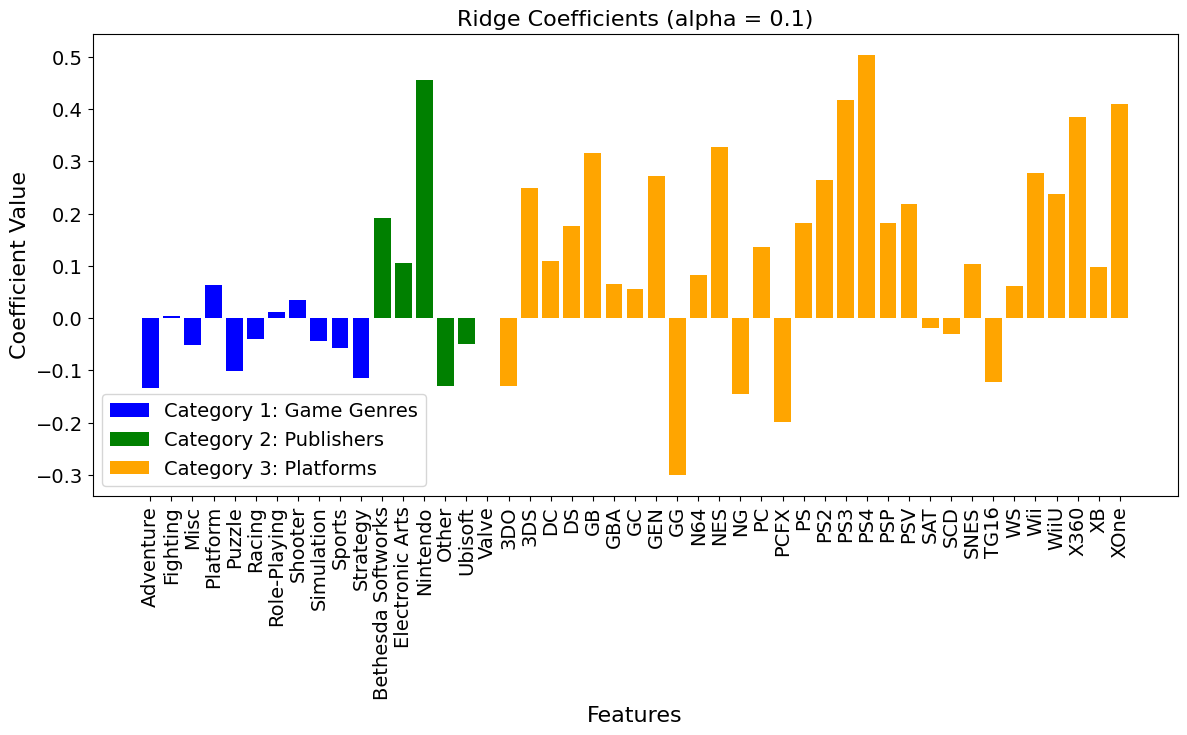

In [102]:
category_1 = {
    "Adventure": -0.1336, "Fighting": 0.0032, "Misc": -0.0508, "Platform": 0.0638, 
    "Puzzle": -0.1012, "Racing": -0.0391, "Role-Playing": 0.0124, "Shooter": 0.0345, "Simulation": -0.0434, 
    "Sports": -0.0575, "Strategy": -0.1138
}
category_2 = {
    "Bethesda Softworks": 0.1918, "Electronic Arts": 0.1057, "Nintendo": 0.4554, "Other": -0.1297, 
    "Ubisoft": -0.0496, "Valve": 0.0000
}
category_3 = {
    "3DO": -0.1291, "3DS": 0.2492, "DC": 0.1098, "DS": 0.1758, "GB": 0.3152, "GBA": 0.0649, "GC": 0.0565, 
    "GEN": 0.2726, "GG": -0.2998, "N64": 0.0832, "NES": 0.3269, "NG": -0.1448, "PC": 0.1358, "PCFX": -0.1986, 
    "PS": 0.1825, "PS2": 0.2636, "PS3": 0.4183, "PS4": 0.5040, "PSP": 0.1825, "PSV": 0.2177, "SAT": -0.0197, 
    "SCD": -0.0313, "SNES": 0.1033, "TG16": -0.1219, "WS": 0.0611, "Wii": 0.2783, "WiiU": 0.2380, 
    "X360": 0.3843, "XB": 0.0984, "XOne": 0.4089
}

features = list(category_1.keys()) + list(category_2.keys()) + list(category_3.keys())
coefficients = list(category_1.values()) + list(category_2.values()) + list(category_3.values())

colors = (["blue"] * len(category_1)) + (["green"] * len(category_2)) + (["orange"] * len(category_3))

plt.figure(figsize=(14, 6))
bars = plt.bar(features, coefficients, color=colors)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Coefficient Value', fontsize=16)
plt.title('Ridge Coefficients (alpha = 0.1)', fontsize=16)
          
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="blue", label="Category 1: Game Genres"),
    Patch(facecolor="green", label="Category 2: Publishers"),
    Patch(facecolor="orange", label="Category 3: Platforms")
]
plt.legend(handles=legend_elements, fontsize=14, loc="best")
plt.show()

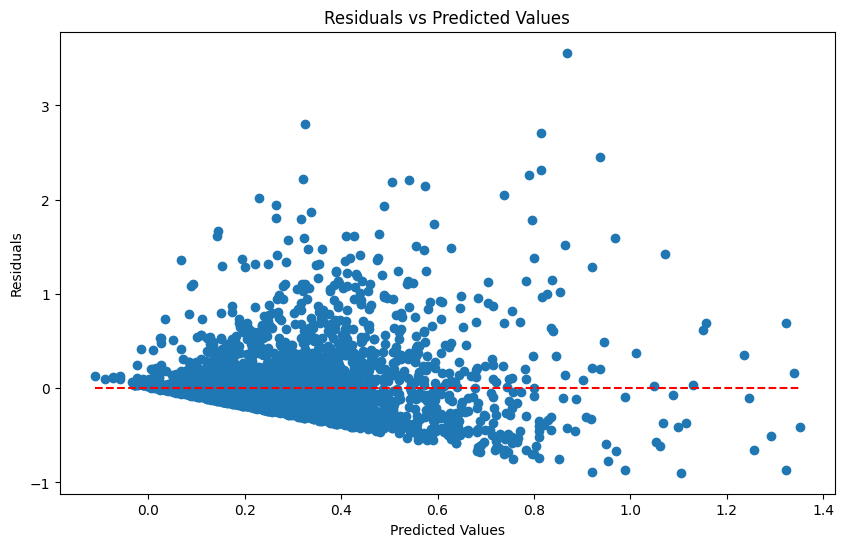

In [103]:
#residual plot
y_pred = best.predict(X_test)

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

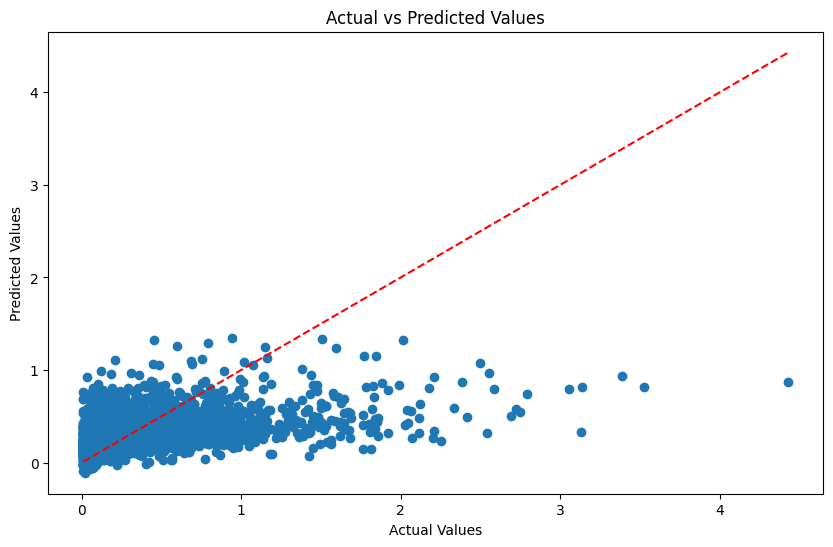

In [104]:
#predicted v actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [105]:
#Set up classification: high-selling game is at a threshold of 0.47
sales1 = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales', 'log_global_sales', 'high_sales']
df_encoded['high_sales'] = (df_encoded['global_sales'] >= 0.47).astype(int) #using 75% percentile (consider mean or median)
y1 = df_encoded['high_sales'].values
X1 = df_encoded.drop(sales1, axis = 1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

model = LogisticRegression(C = 0.1, max_iter=1000)

cv_scores = cross_val_score(model, X1_train_scaled, y1_train, cv=kf, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

model.fit(X1_train_scaled, y1_train)

y1_pred = model.predict(X1_test_scaled)

cm = confusion_matrix(y1_test, y1_pred)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(f"Test Accuracy: {accuracy_score(y1_test, y1_pred):.4f}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report(y1_test, y1_pred, zero_division = 1)}")

Cross-validation scores: [0.77061757 0.77483698 0.78511128 0.76937836 0.77858787]
Mean accuracy: 0.7757
Standard deviation of accuracy: 0.0057
Test Accuracy: 0.7726
Confusion Matrix:
[[2301  123]
 [ 618  217]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2424
           1       0.64      0.26      0.37       835

    accuracy                           0.77      3259
   macro avg       0.71      0.60      0.62      3259
weighted avg       0.75      0.77      0.74      3259



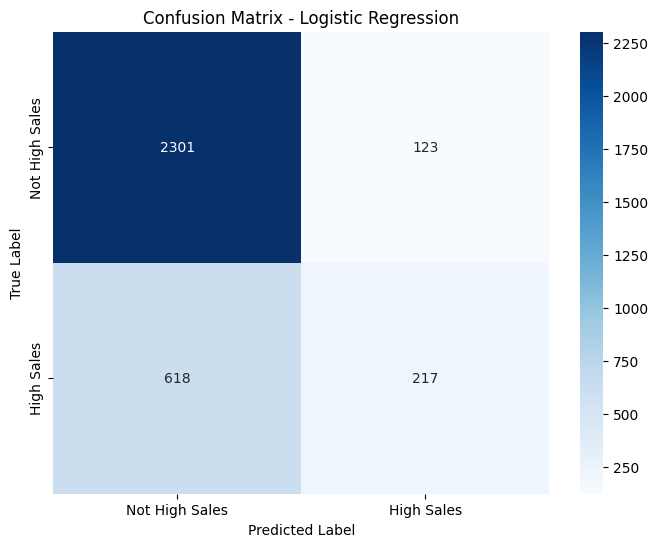

In [106]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not High Sales', 'High Sales'], yticklabels=['Not High Sales', 'High Sales'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

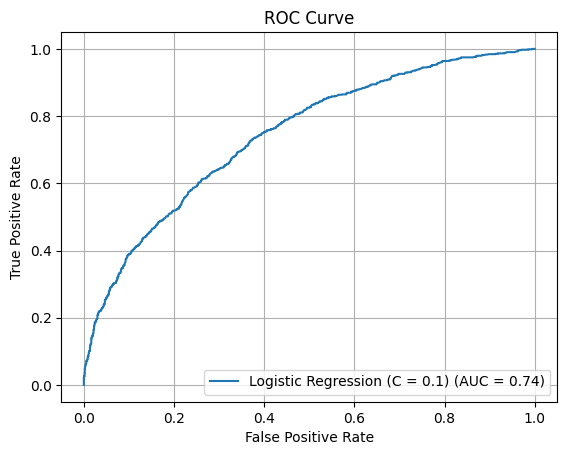

In [107]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

y1_pred_proba = model.predict_proba(X1_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y1_test, y1_pred_proba)

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression (C = 0.1)')
display.plot()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [108]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X1_train, y1_train)
y1_pred_rf = rf_model.predict(X1_test)

acc_rf = accuracy_score(y1_test, y1_pred_rf)
conf_matrix_rf = confusion_matrix(y1_test, y1_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print("Confusion Matrix - Random Forest:\n", conf_matrix_rf)
print("Classification Report - Random Forest:\n", classification_report(y1_test, y1_pred_rf))

Random Forest Accuracy: 0.7754
Confusion Matrix - Random Forest:
 [[2336   88]
 [ 644  191]]
Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      2424
           1       0.68      0.23      0.34       835

    accuracy                           0.78      3259
   macro avg       0.73      0.60      0.60      3259
weighted avg       0.76      0.78      0.73      3259



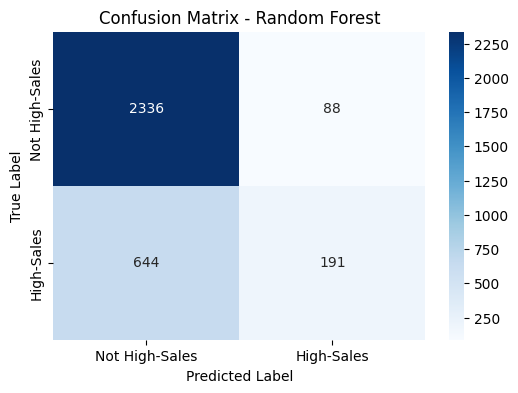

In [48]:
# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=["Not High-Sales", "High-Sales"], yticklabels=["Not High-Sales", "High-Sales"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [109]:
#Neural network
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X1_train_scaled, y1_train)
y1_pred_mlp = mlp_model.predict(X1_test_scaled)

acc_mlp = accuracy_score(y1_test, y1_pred_mlp)
conf_matrix_mlp = confusion_matrix(y1_test, y1_pred_mlp)
print(f"Neural Network Accuracy: {acc_mlp:.4f}")
print("Confusion Matrix - Neural Network:\n", conf_matrix_mlp)
print("Classification Report - Neural Network:\n", classification_report(y1_test, y1_pred_mlp))

Neural Network Accuracy: 0.7723
Confusion Matrix - Neural Network:
 [[2252  172]
 [ 570  265]]
Classification Report - Neural Network:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      2424
           1       0.61      0.32      0.42       835

    accuracy                           0.77      3259
   macro avg       0.70      0.62      0.64      3259
weighted avg       0.75      0.77      0.75      3259



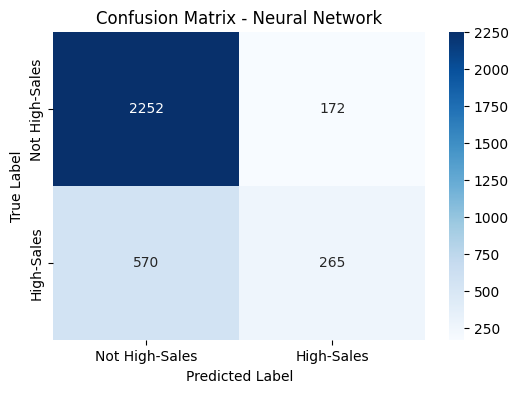

In [110]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=["Not High-Sales", "High-Sales"], yticklabels=["Not High-Sales", "High-Sales"])
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
import statsmodels.api as sm
X2 = X
y2 = df_encoded['global_sales'].values

X2_scaled = scaler.fit_transform(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size = 0.2, random_state = 42)

gamma_model = sm.GLM(y2_train, sm.add_constant(X2_train), family = sm.families.Gamma(link = sm.families.links.Log()))
gamma_results = gamma_model.fit()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                13032
Model:                            GLM   Df Residuals:                    12984
Model Family:                   Gamma   Df Model:                           47
Link Function:                    Log   Scale:                          3.1308
Method:                          IRLS   Log-Likelihood:                -3016.8
Date:                Fri, 07 Mar 2025   Deviance:                       20868.
Time:                        16:06:49   Pearson chi2:                 4.07e+04
No. Iterations:                    20   Pseudo R-squ. (CS):             0.1798
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5583      0.041    -13.648      0.0

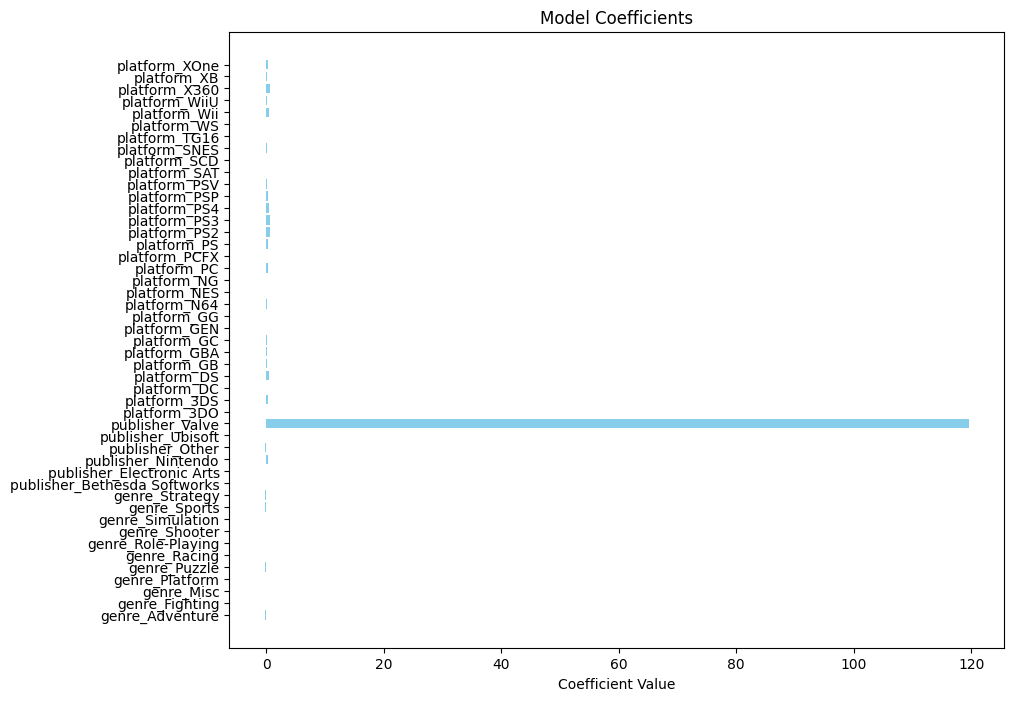

In [112]:
original_feature_names = X.columns.tolist()[1:]  
coefficients = gamma_results.params[1:]  

if len(original_feature_names) != len(coefficients):
    print(f"Mismatch: {len(original_feature_names)} feature names vs {len(coefficients)} coefficients")
else:
    plt.figure(figsize=(10, 8))
    plt.barh(original_feature_names, coefficients, color='skyblue')  # Horizontal bar chart
    plt.xlabel('Coefficient Value')
    plt.title('Model Coefficients')
    plt.show()